In [2]:
!nvidia-smi

Fri May  3 11:27:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   26C    P8    16W / 250W |      0MiB / 12195MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
IMG_WIDTH = 1400
IMG_HEIGHT = 1400
ROW_SLICE = slice(0, 1400)
COL_SLICE = slice(1000, None)

In [4]:
import os
import sys
import numpy as np
sys.path.append("../")
from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from UNet import get_unet

Using TensorFlow backend.


In [5]:
%matplotlib inline

In [6]:
data_dir = "/storage/yw18581/data/"
data_folder = os.path.join(data_dir, 'train_validation_test')

In [7]:
from data_loaders_km3 import data_generator, get_n_iterations
from os import path as p
from tqdm import tqdm

In [8]:
def inference_step(network_model, test_data_generator, predict_steps):

    y_pred = list()

    for _ in tqdm(range(predict_steps)):
        X_batch, _ = next(test_data_generator)
        Y_batch_pred = network_model.predict_on_batch(X_batch)
        #print(Y_batch_pred.shape)
        y_pred.append(Y_batch_pred)
    y_pred = np.concatenate(y_pred, axis=0)

    return y_pred

In [9]:
TRAIN_VAL_TEST_DIR = os.path.join(data_dir, "train_validation_test")
N_EPOCHS=1500
N_FILES = 1
BATCH_SIZE=2

In [10]:
CHECKPOINT_FOLDER_PATH = os.path.join(data_dir, 'trained_models')
TASK_NAME = 'UNet_training_generator_{}epochs'.format(N_EPOCHS)
TASK_FOLDER_PATH = os.path.join(CHECKPOINT_FOLDER_PATH, TASK_NAME)

In [11]:
TRAINING_WEIGHTS_FILEPATH=os.path.join(CHECKPOINT_FOLDER_PATH,'retrained_UNet_1000+500epochs.hdf5')

In [12]:
model1500 = get_unet()
model1500.load_weights(TRAINING_WEIGHTS_FILEPATH)

In [12]:
fname_1mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_1mm_clean.npz")]
fname_2mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_2mm_clean.npz")]
fname_3mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_3mm_clean.npz")]
fname_4mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_4mm_clean.npz")]
fname_10mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_10mm_clean.npz")]
fname_15mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_15mm_clean.npz")]
fname_20mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_20mm_clean.npz")]
fname_25mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_25mm_clean.npz")]
fname_30mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_30mm_clean.npz")]
fname_35mm = [os.path.join(TRAIN_VAL_TEST_DIR,"Xy_35mm_clean.npz")]

In [16]:
def load_indices(pos):
    indices = np.load(os.path.join(data_folder,"RF_train_test_indices_80_20_"+pos+"_clean.npz"))
    train_indices = indices["train"]
    test_indices = indices["test"]
    return train_indices, test_indices

In [25]:
_, test_indices_1mm = load_indices("1mm")
_, test_indices_2mm = load_indices("2mm")
_, test_indices_3mm = load_indices("3mm")
_, test_indices_4mm = load_indices("4mm")
_, test_indices_10mm = load_indices("10mm")
_, test_indices_15mm = load_indices("15mm")
_, test_indices_20mm = load_indices("20mm")
_, test_indices_25mm = load_indices("25mm")
_, test_indices_30mm = load_indices("30mm")
_, test_indices_35mm = load_indices("35mm")

In [26]:
def data_gen(fname, test_indices):
    return data_generator(fname, batch_size=BATCH_SIZE, fdata=lambda X: X[test_indices], ftarget = lambda y: y)

In [27]:
data_gen_1mm = data_gen(fname_1mm, test_indices_1mm)
data_gen_2mm = data_gen(fname_2mm, test_indices_2mm)
data_gen_3mm = data_gen(fname_3mm , test_indices_3mm)
data_gen_4mm = data_gen(fname_4mm, test_indices_4mm)
data_gen_10mm = data_gen(fname_10mm, test_indices_10mm)
data_gen_15mm = data_gen(fname_15mm, test_indices_15mm)
data_gen_20mm = data_gen(fname_20mm, test_indices_20mm)
data_gen_25mm = data_gen(fname_25mm, test_indices_25mm)
data_gen_30mm = data_gen(fname_30mm, test_indices_30mm)
data_gen_35mm = data_gen(fname_35mm, test_indices_35mm)


In [13]:
def data_gen(fname):
    return data_generator(fname, batch_size=BATCH_SIZE, ftarget = lambda y: y)

In [14]:
data_gen_1mm = data_gen(fname_1mm)
data_gen_2mm = data_gen(fname_2mm)
data_gen_3mm = data_gen(fname_3mm)
data_gen_4mm = data_gen(fname_4mm)
data_gen_10mm = data_gen(fname_10mm)
data_gen_15mm = data_gen(fname_15mm)
data_gen_20mm = data_gen(fname_20mm)
data_gen_25mm = data_gen(fname_25mm)
data_gen_30mm = data_gen(fname_30mm)
data_gen_35mm = data_gen(fname_35mm)


In [15]:
def run_predictions_and_save(model, fname_in, data_gen, file_key):
    steps, evt = get_n_iterations(fname_in, batch_size=BATCH_SIZE)
    print(steps, evt)
    pred = inference_step(model, data_gen, steps)
    pred = pred.astype(np.uint8)*255
    Xd = np.load(fname_in[0])
    X_out =Xd['x'][...,0]
    dist_out = Xd['dist']
    np.savez_compressed(os.path.join(TASK_FOLDER_PATH,"Xy_"+file_key+"_predicted_UNet.npz"),
                   x= X_out, y=pred[...,0], dist = dist_out)
    return

In [54]:
run_predictions_and_save(model1500, fname_1mm, data_gen_1mm, "1mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_1mm_clean.npz']


  0%|          | 0/87 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_1mm_clean.npz
(174, 1400, 1400, 1)
87 174


100%|██████████| 87/87 [00:21<00:00,  2.45it/s]


In [16]:
run_predictions_and_save(model1500, fname_2mm, data_gen_2mm, "2mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_2mm_clean.npz']


  0%|          | 0/150 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_2mm_clean.npz
(300, 1400, 1400, 1)
150 300


100%|██████████| 150/150 [00:44<00:00,  4.88it/s]


In [17]:
run_predictions_and_save(model1500, fname_3mm, data_gen_3mm, "3mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_3mm_clean.npz']


  0%|          | 0/85 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_3mm_clean.npz
(170, 1400, 1400, 1)
85 170


100%|██████████| 85/85 [00:21<00:00,  4.94it/s]


In [18]:
run_predictions_and_save(model1500, fname_4mm, data_gen_4mm, "4mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_4mm_clean.npz']


  0%|          | 0/81 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_4mm_clean.npz
(162, 1400, 1400, 1)
81 162


100%|██████████| 81/81 [00:20<00:00,  4.93it/s]


In [19]:
run_predictions_and_save(model1500, fname_10mm, data_gen_10mm, "10mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_10mm_clean.npz']


  0%|          | 0/82 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_10mm_clean.npz
(163, 1400, 1400, 1)
82 163


100%|██████████| 82/82 [00:22<00:00,  1.38it/s]


In [20]:
run_predictions_and_save(model1500, fname_15mm, data_gen_15mm, "15mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_15mm_clean.npz']


  0%|          | 0/150 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_15mm_clean.npz
(300, 1400, 1400, 1)
150 300


100%|██████████| 150/150 [00:38<00:00,  4.93it/s]


In [21]:
run_predictions_and_save(model1500, fname_20mm, data_gen_20mm, "20mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_20mm_clean.npz']


  0%|          | 0/87 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_20mm_clean.npz
(173, 1400, 1400, 1)
87 173


100%|██████████| 87/87 [00:22<00:00,  3.93it/s]


In [22]:
run_predictions_and_save(model1500, fname_25mm, data_gen_25mm, "25mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_25mm_clean.npz']


  0%|          | 0/95 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_25mm_clean.npz
(190, 1400, 1400, 1)
95 190


100%|██████████| 95/95 [00:24<00:00,  4.91it/s]


In [23]:
run_predictions_and_save(model1500, fname_30mm, data_gen_30mm, "30mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_30mm_clean.npz']


  0%|          | 0/91 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_30mm_clean.npz
(181, 1400, 1400, 1)
91 181


100%|██████████| 91/91 [00:23<00:00,  3.90it/s]


In [24]:
run_predictions_and_save(model1500, fname_35mm, data_gen_35mm,"35mm_clean")

['/storage/yw18581/data/train_validation_test/Xy_35mm_clean.npz']


  0%|          | 0/90 [00:00<?, ?it/s]

/storage/yw18581/data/train_validation_test/Xy_35mm_clean.npz
(179, 1400, 1400, 1)
90 179


100%|██████████| 90/90 [00:23<00:00,  3.90it/s]


In [25]:
os.listdir(TASK_FOLDER_PATH)

['Xy_test_predicted_UNet.npz',
 'Xy_3mm_predicted_UNet.npz',
 'Xy_1mm_predicted_UNet.npz',
 'Xy_2mm_predicted_UNet.npz',
 'Xy_4mm_predicted_UNet.npz',
 'Xy_10mm_predicted_UNet.npz',
 'Xy_15mm_predicted_UNet.npz',
 'Xy_20mm_predicted_UNet.npz',
 'Xy_25mm_predicted_UNet.npz',
 'Xy_35mm_predicted_UNet.npz',
 'Xy_30mm_predicted_UNet.npz',
 'Xy_1mm_clean_test_predicted_UNet.npz',
 'Xy_3mm_clean_predicted_UNet.npz',
 'Xy_10mm_clean_test_predicted_UNet.npz',
 'Xy_15mm_clean_test_predicted_UNet.npz',
 'Xy_20mm_clean_test_predicted_UNet.npz',
 'Xy_25mm_clean_test_predicted_UNet.npz',
 'Xy_2mm_clean_test_predicted_UNet.npz',
 'Xy_30mm_clean_test_predicted_UNet.npz',
 'Xy_35mm_clean_test_predicted_UNet.npz',
 'Xy_4mm_clean_test_predicted_UNet.npz',
 'Xy_1mm_clean_predicted_UNet.npz',
 'Xy_2mm_clean_predicted_UNet.npz',
 'Xy_4mm_clean_predicted_UNet.npz',
 'Xy_10mm_clean_predicted_UNet.npz',
 'Xy_15mm_clean_predicted_UNet.npz',
 'Xy_20mm_clean_predicted_UNet.npz',
 'Xy_25mm_clean_predicted_UNet.np

In [1]:
model

NameError: name 'model' is not defined

In [15]:
model1500.history

AttributeError: 'Model' object has no attribute 'history'

In [16]:
from keras.models import load_model
model = load_model(TRAINING_WEIGHTS_FILEPATH)

ValueError: Unknown loss function:dice_coef_loss

In [13]:
os.listdir(TASK_FOLDER_PATH)

['Xy_test_predicted_UNet.npz',
 'Xy_3mm_predicted_UNet.npz',
 'Xy_1mm_predicted_UNet.npz',
 'Xy_2mm_predicted_UNet.npz',
 'Xy_4mm_predicted_UNet.npz',
 'Xy_10mm_predicted_UNet.npz',
 'Xy_15mm_predicted_UNet.npz',
 'Xy_20mm_predicted_UNet.npz',
 'Xy_25mm_predicted_UNet.npz',
 'Xy_35mm_predicted_UNet.npz',
 'Xy_30mm_predicted_UNet.npz',
 'Xy_1mm_clean_test_predicted_UNet.npz',
 'Xy_3mm_clean_predicted_UNet.npz',
 'Xy_10mm_clean_test_predicted_UNet.npz',
 'Xy_15mm_clean_test_predicted_UNet.npz',
 'Xy_20mm_clean_test_predicted_UNet.npz',
 'Xy_25mm_clean_test_predicted_UNet.npz',
 'Xy_2mm_clean_test_predicted_UNet.npz',
 'Xy_30mm_clean_test_predicted_UNet.npz',
 'Xy_35mm_clean_test_predicted_UNet.npz',
 'Xy_4mm_clean_test_predicted_UNet.npz',
 'Xy_1mm_clean_predicted_UNet.npz',
 'Xy_2mm_clean_predicted_UNet.npz',
 'Xy_4mm_clean_predicted_UNet.npz',
 'Xy_10mm_clean_predicted_UNet.npz',
 'Xy_15mm_clean_predicted_UNet.npz',
 'Xy_20mm_clean_predicted_UNet.npz',
 'Xy_25mm_clean_predicted_UNet.np

In [31]:
X = np.load(os.path.join(TASK_FOLDER_PATH, "Xy_25mm_clean_predicted_UNet.npz"))["x"]
y = np.load(os.path.join(TASK_FOLDER_PATH, "Xy_25mm_clean_predicted_UNet.npz"))["y"]

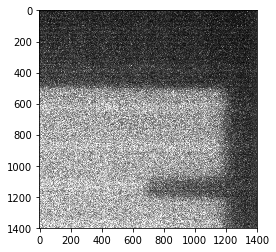

In [35]:
plt.imshow(X[0], cmap='gray')
plt.savefig("original_image_25mm.png")

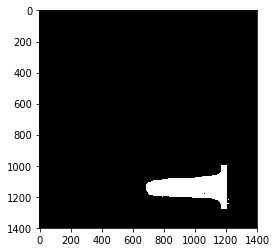

In [36]:

plt.savefig("unet_generated_mask_25mm.png")

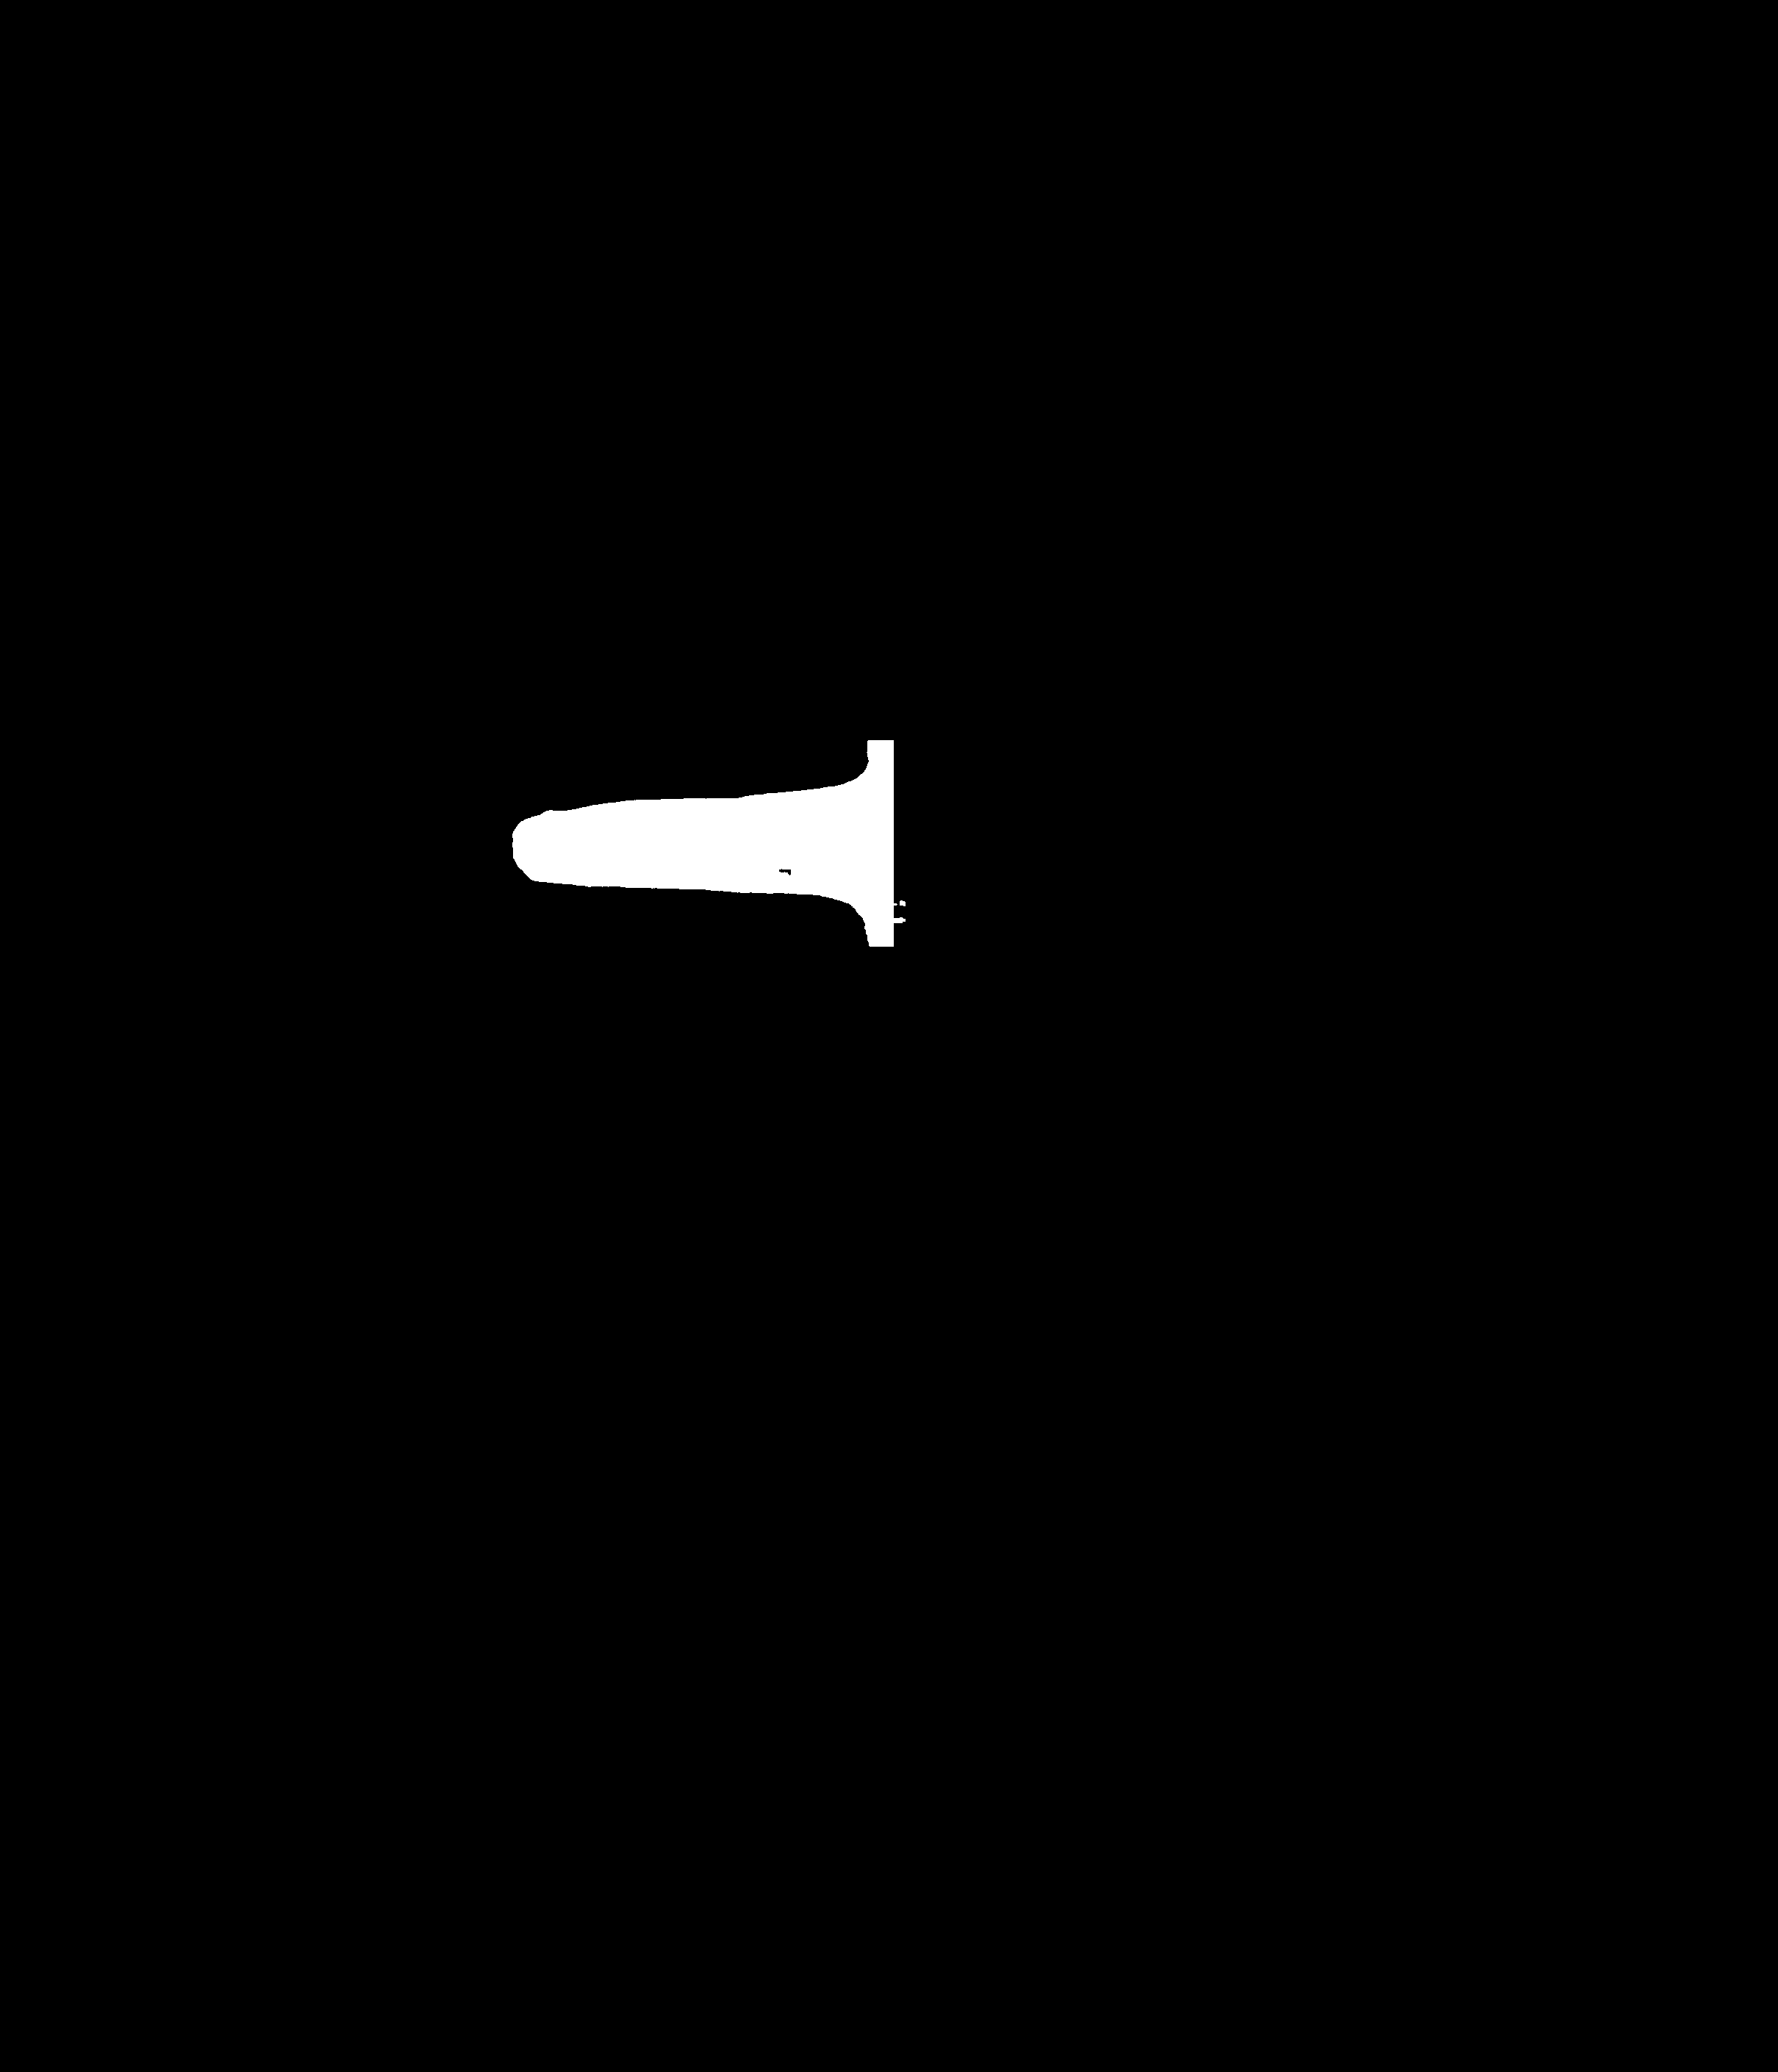

In [38]:
plt.figure(figsize=(2400/96, 2800/96), dpi=96)
plt.style.use('dark_background')
plt.axes([0,0,1,1], frameon=False)
fig= plt.imshow(y[0], cmap='gray')
plt.ylim(2800,0)
plt.xlim(0,2400)
plt.box(False)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig("unet_generated_mask.png")

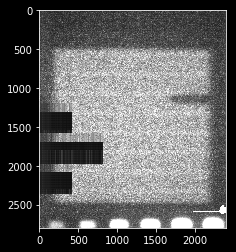

In [45]:
plt.imshow(imread(os.path.join(data_dir,"10x10_25mm_8bit", "File_1.tiff")), cmap='gray')